In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import pydicom

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Data collection**

In [2]:
#Read in the test and train files, print first few rows of train file.
train = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/train.csv")
test = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/test.csv")
train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [3]:
#Summary of the train dataset:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
dtypes: bool(1), float64(2)

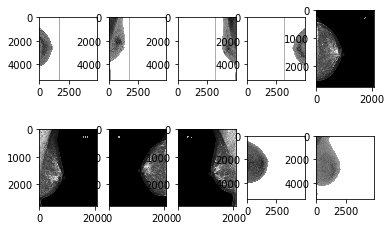

In [4]:
#Visualize the first 10 mammograms in the train dataset:
fig, axs = plt.subplots(2,5)

for i in range(10):
    patient_id = train['patient_id'][i]
    image_id = train['image_id'][i]
    path_img = '/kaggle/input/rsna-breast-cancer-detection/train_images/' + str(patient_id) + '/' + str(image_id) + '.dcm'
    im = pydicom.dcmread(path_img)
    arr = im.pixel_array
    axs[i//5][(i%5)].imshow(np.array(arr), interpolation='none', cmap='gray')

In [5]:
#We see that there are 2 kinds of images: the ones with a white background, and
#the ones with a black background. The two kinds of images correspond to two different 
#photometric interpretations (MONOCHROME1 or MONOCHROME2):
for i in range(10):
    patient_id = train['patient_id'][i]
    image_id = train['image_id'][i]
    path_img = '/kaggle/input/rsna-breast-cancer-detection/train_images/' + str(patient_id) + '/' + str(image_id) + '.dcm'
    im = pydicom.dcmread(path_img)
    print(im.PhotometricInterpretation)
    
#See the website 
#https://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_C.7.6.3.html#sect_C.7.6.3.1
#for more details about photometric interpretations.

MONOCHROME1
MONOCHROME1
MONOCHROME1
MONOCHROME1
MONOCHROME2
MONOCHROME2
MONOCHROME2
MONOCHROME2
MONOCHROME1
MONOCHROME1


# **Data organization**

# **Data definition**

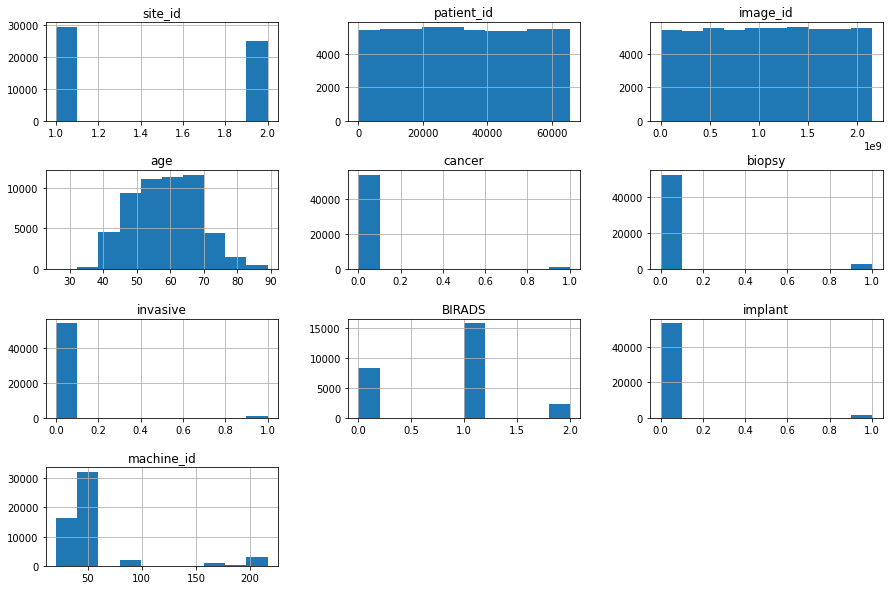

In [6]:
#Visualize the distribution of feature values by histograms.
train.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

# **Data cleaning**

In [7]:
#Count the number of missing values in each column and sort the columns by missing percentage.
missing = pd.concat([train.isnull().sum(), 100 * train.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='%', ascending=False)

,count,%
BIRADS,28420,51.950426
density,25236,46.130223
age,37,0.067634
site_id,0,0.000000
patient_id,0,0.000000
image_id,0,0.000000
laterality,0,0.000000
view,0,0.000000
cancer,0,0.000000
biopsy,0,0.000000


In [8]:
#Find out if image_id is unique.
train['image_id'].value_counts().head()

462822612     1
443006806     1
587208264     1
777292277     1
1605015271    1
Name: image_id, dtype: int64